1. Import and Install Dependencies

1.1 Install Dependencies

In [4]:
%pip install tensorflow matplotlib tensorflow-io

Note: you may need to restart the kernel to use updated packages.


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
from sklearn import preprocessing
import random as rn
from keras.layers import Dense
from keras import Input
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
import tensorflow as tf
import tensorflow_io as tfio
import random

2023-11-27 10:17:36.416629: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 10:17:38.113392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2. Data Loading

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-27 10:17:40.147650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 10:17:40.344794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 10:17:40.344898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2023-11-27 10:17:40.427353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


1 Physical GPUs, 1 Logical GPUs


2023-11-27 10:17:40.427892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 10:17:40.428167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 10:17:43.241010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 10:17:43.241166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1726] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-11-27 10:17:43.241719: I tensorflow/compiler/xla/stream_executor/cuda/cu

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
DATA_DIR = os.path.join('data', 'train/')
def get_data_dir(label):
    return os.path.join('data', 'train2', label, '/')

In [10]:
import os
import librosa

# Directory containing the audio files
dir_path = os.path.join('data', 'train/')

# List to store the lengths of the audio files
lengths = []

# Iterate over all files in the directory
for file in os.listdir(dir_path):
    # Skip directories
    if os.path.isdir(os.path.join(dir_path, file)):
        continue

    # Load the audio file
    wav, sr = librosa.load(os.path.join(dir_path, file), sr=16000)
    
    # Calculate the length of the audio file in seconds and append it to the list
    lengths.append(len(wav) / sr)

# Convert the list to a TensorFlow tensor
lengths_tensor = tf.convert_to_tensor(lengths)

# Calculate and print the mean, min, and max
print('Mean:', tf.math.reduce_mean(lengths_tensor).numpy())
print('Min:', tf.math.reduce_min(lengths_tensor).numpy())
print('Max:', tf.math.reduce_max(lengths_tensor).numpy())

Mean: 0.40892664
Min: 0.36
Max: 0.75


In [11]:
check_dir = os.path.join('data', 'train/')

wav, sr = librosa.load(check_dir + 'W-04.wav', sr=16000)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (8000,)
length: 0.5 secs


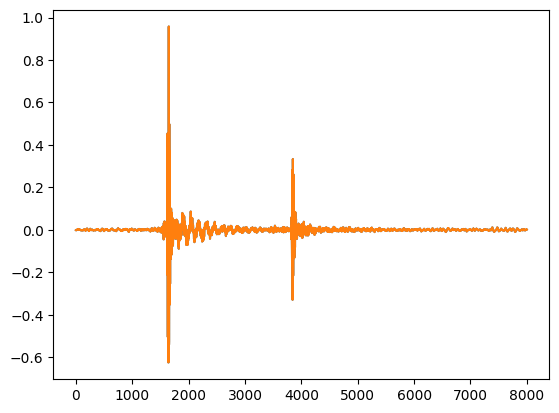

In [12]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:8000]))

In [13]:
train_mlp = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []

test_mlp = []
test_spectrograms = []
test_mel_spectrograms = []
test_mfccs = []
test_y = []

# 모든 음성파일의 길이가 같도록 후위에 padding 처리
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

frame_length = 0.025
frame_stride = 0.0010

In [14]:
from sklearn.model_selection import train_test_split

In [15]:


def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav



Spectogram and binary classification by each label

In [16]:
def get_spectrogram(filename):
    wav = load_wav_16k_mono(filename)
    spectrogram = np.abs(librosa.stft(wav.numpy()))
    padded_spectrogram = pad2d(spectrogram, 400)
    return padded_spectrogram

In [17]:
def get_spectrogram(filename):
    wav = load_wav_16k_mono(filename)
    wav = wav[:8000]
    zero_padding = tf.zeros([8000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

In [18]:
def create_binary_class_model(key):
    X = []
    y = []
    
    data_dir = os.path.join('data', 'train/')
    for filename in os.listdir(data_dir):
        if '.wav' not in filename:
            continue

        spectrogram = get_spectrogram(data_dir + filename)
        label = 1 if key == filename[0] else 0  # 'Q' is 1, 'not Q' is 0

        X.append(spectrogram)
        y.append(label)

    train_spectrograms, test_spectrograms, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

    train_spectrograms = np.array(train_spectrograms)
    train_y = np.array(train_y)  

    test_spectrograms = np.array(test_spectrograms)
    test_y = np.array(test_y)  

    print('train_mfccs:', train_spectrograms.shape)
    print('train_y:', train_y.shape)

    print('test_mfccs:', test_spectrograms.shape)
    print('test_y:', test_y.shape)
    train_spectrograms = np.expand_dims(train_spectrograms, -1)
    test_spectrograms = np.expand_dims(test_spectrograms, -1)
    print('train_spectograms shape:', train_spectrograms.shape)
    print('test_spectograms shape:', test_spectrograms.shape)
    ip = Input(shape=train_spectrograms[0].shape)

    m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
    m = MaxPooling2D(pool_size=(4,4))(m)

    m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
    m = MaxPooling2D(pool_size=(4,4))(m)

    m = Conv2D(32 * 3, kernel_size=(4, 4), activation='relu')(ip)
    m = MaxPooling2D(pool_size=(4,4))(m)

    m = Flatten()(m)

    m = Dense(64, activation='relu')(m)

    m = Dense(32, activation='relu')(m)

    op = Dense(1, activation='sigmoid')(m) 

    model = Model(ip, op)

    model.summary()

    model.compile(loss='binary_crossentropy',  
                optimizer='adam',
                metrics=['accuracy'])

    history = model.fit(train_spectrograms,
                        train_y,
                        epochs=100,
                        batch_size=16,
                        verbose=1,
                        validation_data=(test_spectrograms, test_y))
    
    
    loss, accuracy = model.evaluate(test_spectrograms, test_y)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    return model, history

Q

In [19]:
Q_model, Q_history = create_binary_class_model('Q')

2023-11-27 10:17:51.529074: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 FMA


train_mfccs: (1177, 241, 257)
train_y: (1177,)
test_mfccs: (295, 241, 257)
test_y: (295,)
train_spectograms shape: (1177, 241, 257, 1)
test_spectograms shape: (295, 241, 257, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 241, 257, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 238, 254, 96)      1632      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 59, 63, 96)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 356832)            0         
                                                                 
 dense (Dense)               (None, 64)                22837312  
               

2023-11-27 10:19:14.317661: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 291599396 exceeds 10% of free system memory.
2023-11-27 10:19:14.695233: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 291599396 exceeds 10% of free system memory.


Epoch 1/100


2023-11-27 10:19:18.274177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-27 10:19:21.854099: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fefba3e24f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 10:19:21.854158: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-11-27 10:19:22.012110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-27 10:19:22.403433: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9567

2023-11-27 10:19:27.754104: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73085660 exceeds 10% of free system memory.
2023-11-27 10:19:28.985937: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73085660 exceeds 10% of free system memory.


74/74 [==============================] - 15s 78ms/step - loss: 0.1158 - accuracy: 0.9567 - val_loss: 0.0389 - val_accuracy: 0.9797
Epoch 2/100
74/74 [==============================] - 3s 40ms/step - loss: 0.0128 - accuracy: 0.9941 - val_loss: 0.0218 - val_accuracy: 0.9932
Epoch 3/100
74/74 [==============================] - 3s 43ms/step - loss: 0.0084 - accuracy: 0.9983 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 4/100
74/74 [==============================] - 3s 39ms/step - loss: 3.3940e-04 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 0.9966
Epoch 5/100
74/74 [==============================] - 3s 39ms/step - loss: 1.0696e-04 - accuracy: 1.0000 - val_loss: 9.0142e-04 - val_accuracy: 1.0000
Epoch 6/100
74/74 [==============================] - 3s 40ms/step - loss: 4.6482e-05 - accuracy: 1.0000 - val_loss: 8.3779e-04 - val_accuracy: 1.0000
Epoch 7/100
74/74 [==============================] - 3s 39ms/step - loss: 3.5008e-05 - accuracy: 1.0000 - val_loss: 8.7453e-04 - val_accura

2023-11-27 10:24:19.706088: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73085660 exceeds 10% of free system memory.


10/10 [==============================] - 0s 14ms/step - loss: 1.1800e-04 - accuracy: 1.0000
Test Loss: 0.0001179955797852017
Test Accuracy: 1.0


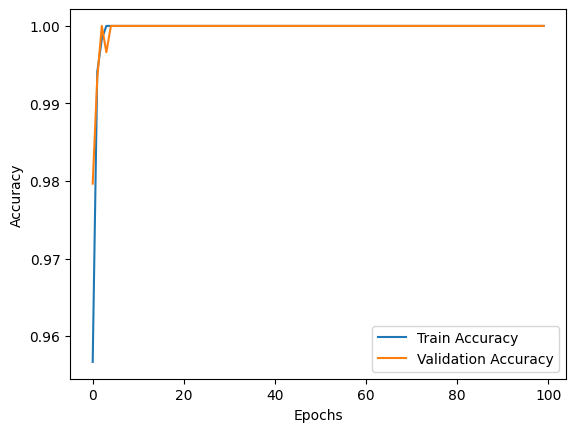

In [20]:
plt.plot(Q_history.history['accuracy'], label='Train Accuracy')
plt.plot(Q_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Text(0, 0.5, 'Accuracy [%]')

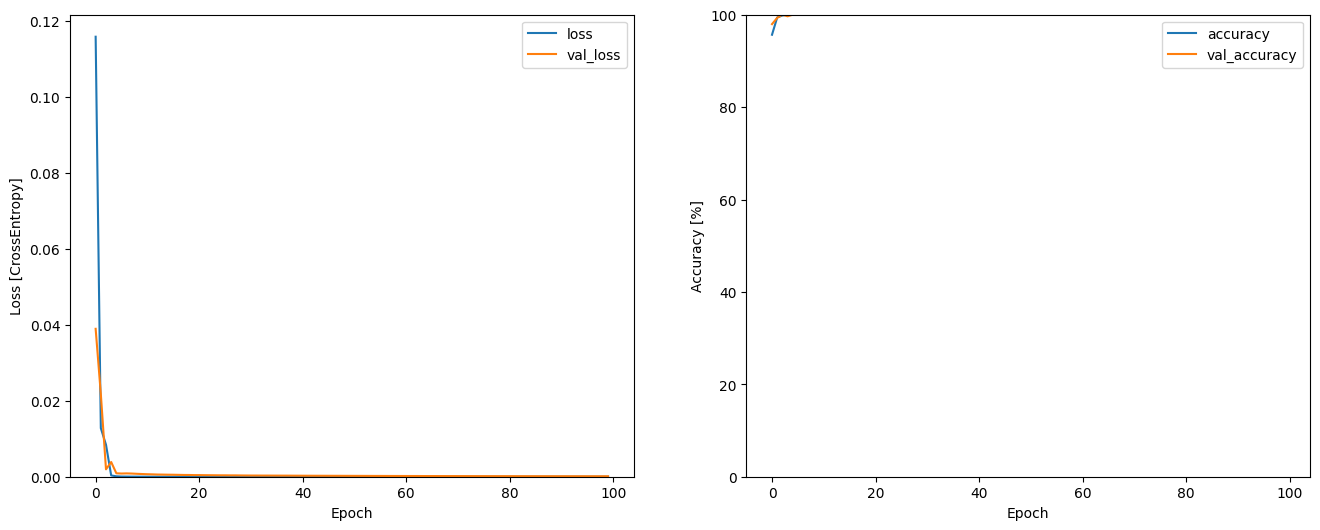

In [21]:
metrics = Q_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(Q_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(Q_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [22]:
import random

def test_random_file():
    key = random.choice(['Q', 'W', 'E', 'R'])
    number = random.randint(0, 200)
    filename = f"{DATA_DIR}{key}-{number}.wav"

    try:
        spectrogram = get_spectrogram(filename)
    except FileNotFoundError:
        print(f"The file '{filename}' does not exist.")
        return

    spectrogram = np.expand_dims(spectrogram, 0)
    prediction = Q_model.predict(spectrogram)
    is_q = prediction[0] > 0.5

    print(f"The input file is '{filename}' and this is {'Q' if is_q else 'not Q'}.")
    print(f"The model thinks it has {prediction[0][0]*100:.2f}%  chacne of being Q.")

# Call the function to test a random file
test_random_file()

2023-11-27 10:24:20.878047: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/train/Q-3.wav; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} data/train/Q-3.wav; No such file or directory [Op:ReadFile]

In [ ]:
Q_model.save('/home/hyochung/Keyboard_DL') #save mdoel

In [ ]:
R_model, R_history = create_binary_class_model('R')

In [ ]:
def test_random_file():
    key = random.choice(['Q', 'W', 'E', 'R'])
    number = random.randint(0, 200)
    
    key = 'R'
    number = 116
    DATA_DIR = os.path.join('data', 'test', 'seperate/')
    
    filename = f"{DATA_DIR}{key}-{number}.wav"

    try:
        spectrogram = get_spectrogram(filename)
    except FileNotFoundError:
        print(f"The file '{filename}' does not exist.")
        return

    spectrogram = np.expand_dims(spectrogram, 0)
    prediction = Q_model.predict(spectrogram)
    is_q = prediction[0] > 0.9

    print(f"The input file is '{filename}' and this is {'R' if is_q else 'not R'}.")
    print(f"The model thinks it has {prediction[0][0]*100:.2f}%  chacne of being R.")
# Call the function to test a random file
test_random_file()

1/1 [==============================] - 0s 23ms/step
The input file is 'data/test/seperate/R-116.wav' and this is not R.
The model thinks it has 0.00%  chacne of being R.


In [ ]:
def test_random_file():
    key = random.choice(['Q', 'W', 'E', 'R'])
    number = random.randint(0, 200)
    filename = f"{DATA_DIR}{key}-{number}.wav"

    try:
        spectrogram = get_spectrogram(filename)
    except FileNotFoundError:
        print(f"The file '{filename}' does not exist.")
        return

    spectrogram = np.expand_dims(spectrogram, 0)
    prediction = R_model.predict(spectrogram)
    is_q = prediction[0] > 0.5

    print(f"The input file is '{filename}' and this is {'R' if is_q else 'not R'}.")
    print(f"The model thinks it has {prediction[0][0]*100:.2f}%  chacne of being R.")
# Call the function to test a random file
test_random_file()

Long recording predictions

In [ ]:
long_record_QQ = load_wav_16k_mono(os.path.join('data', 'test', 'Qqwweerr_2.wav'))
audio_slices = tf.keras.utils.timeseries_dataset_from_array(long_record_QQ, long_record_QQ, sequence_length=8000, sequence_stride=8000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
def preprocess_spectogram(samples, index):
    samples = samples[0]
    zero_padding = tf.zeros([8000] - tf.shape(samples), dtype=tf.float32)
    wav = tf.concat([zero_padding, samples],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(long_record_QQ, long_record_QQ, sequence_length=8000, sequence_stride=8000, batch_size=1)
audio_slices = audio_slices.map(preprocess_spectogram)  
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = Q_model.predict(audio_slices)
yhat = [1 if prediction > 0.70 else 0 for prediction in yhat]

In [ ]:
yhat

In [ ]:
long_record_QW = load_wav_16k_mono(os.path.join('data', 'test', 'Qwer-2.wav'))
audio_slices = tf.keras.utils.timeseries_dataset_from_array(long_record_QW, long_record_QW, sequence_length=8000, sequence_stride=8000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()
def preprocess_spectogram(samples, index):
    samples = samples[0]
    zero_padding = tf.zeros([8000] - tf.shape(samples), dtype=tf.float32)
    wav = tf.concat([zero_padding, samples],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    return spectrogram
audio_slices = tf.keras.utils.timeseries_dataset_from_array(long_record_QW, long_record_QW, sequence_length=8000, sequence_stride=8000, batch_size=1)
audio_slices = audio_slices.map(preprocess_spectogram)  
audio_slices = audio_slices.batch(64)
yhat = Q_model.predict(audio_slices)
yhat = [1 if prediction > 0.90 else 0 for prediction in yhat]
yhat

In [ ]:
long_record_QW = load_wav_16k_mono(os.path.join('data', 'test', 'Qwer-2.wav'))
audio_slices = tf.keras.utils.timeseries_dataset_from_array(long_record_QW, long_record_QW, sequence_length=8000, sequence_stride=8000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()
def preprocess_spectogram(samples, index):
    samples = samples[0]
    zero_padding = tf.zeros([8000] - tf.shape(samples), dtype=tf.float32)
    wav = tf.concat([zero_padding, samples],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    return spectrogram
audio_slices = tf.keras.utils.timeseries_dataset_from_array(long_record_QW, long_record_QW, sequence_length=8000, sequence_stride=8000, batch_size=1)
audio_slices = audio_slices.map(preprocess_spectogram)  
audio_slices = audio_slices.batch(64)
yhat = R_model.predict(audio_slices)
yhat = [1 if prediction > 0.90 else 0 for prediction in yhat]
yhat